# Optimization of a State-to-State Transfer in a Two-Level-System

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
%watermark -v --iversions

Python implementation: CPython
Python version       : 3.8.1
IPython version      : 7.24.1

qutip     : 4.6.1
matplotlib: 3.4.2
numpy     : 1.20.3
krotov    : 1.2.1+dev
scipy     : 1.6.3



$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2}\mid{#2}\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

This first example illustrates the basic use of the `krotov` package by solving
a simple canonical optimization problem: the transfer of population in a two
level system.

## Two-level-Hamiltonian

We consider the Hamiltonian $\op{H}_{0} = - \frac{\omega}{2} \op{\sigma}_{z}$, representing
a simple qubit with energy level splitting $\omega$ in the basis
$\{\ket{0},\ket{1}\}$. The control field $\epsilon(t)$ is assumed to couple via
the Hamiltonian $\op{H}_{1}(t) = \epsilon(t) \op{\sigma}_{x}$ to the qubit,
i.e., the control field effectively drives transitions between both qubit
states.

In [2]:
def hamiltonian(omega=1.0, ampl0=0.2):
    """Two-level-system Hamiltonian

    Args:
        omega (float): energy separation of the qubit levels
        ampl0 (float): constant amplitude of the driving field
    """
    H0 = -0.5 * omega * qutip.operators.sigmaz()
    H1 = qutip.operators.sigmax()

    def guess_control(t, args):
        return ampl0 * krotov.shapes.flattop(
            t, t_start=0, t_stop=5, t_rise=0.3, func="blackman"
        )

    return [H0, [H1, guess_control]]


In [3]:
H = hamiltonian()

The control field here switches on from zero at $t=0$ to it's maximum amplitude
0.2 within the time period 0.3 (the switch-on shape is half a [Blackman pulse](https://en.wikipedia.org/wiki/Window_function#Blackman_window)).
It switches off again in the time period 0.3 before the
final time $T=5$). We use a time grid with 500 time steps between 0 and $T$:

In [4]:
tlist = np.linspace(0, 5, 500)

In [5]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

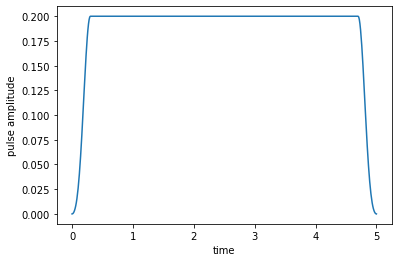

In [6]:
plot_pulse(H[1][1], tlist)

## Optimization target

The `krotov` package requires the goal of the optimization to be described by a
list of `Objective` instances. In this example, there is only a single
objective: the state-to-state transfer from initial state $\ket{\Psi_{\init}} =
\ket{0}$ to the target state $\ket{\Psi_{\tgt}} = \ket{1}$, under the dynamics
of the Hamiltonian $\op{H}(t)$:

In [7]:
objectives = [
    krotov.Objective(
        initial_state=qutip.ket("0"), target=qutip.ket("1"), H=H
    )
]

objectives

[Objective[|Ψ₀(2)⟩ to |Ψ₁(2)⟩ via [H₀[2,2], [H₁[2,2], u₁(t)]]]]

In addition, we would like to maintain the property of the control field to be
zero at $t=0$ and $t=T$, with a smooth switch-on and switch-off. We can define
an "update shape" $S(t) \in [0, 1]$ for this purpose: Krotov's method will
update the field at each point in time proportionally to $S(t)$; wherever
$S(t)$ is zero, the optimization will not change the value of the control from
the original guess.

In [8]:
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=5, t_rise=0.3, t_fall=0.3, func='blackman'
    )

Beyond the shape, Krotov's method uses a parameter $\lambda_a$  for each control
field that determines the overall magnitude of the respective field in each
iteration (the smaller $\lambda_a$, the larger the update; specifically, the
update is proportional to $\frac{S(t)}{\lambda_a}$). Both the update-shape
$S(t)$ and the $\lambda_a$ parameter must be passed to the optimization routine
as "pulse options":

In [9]:
pulse_options = {
    H[1][1]: dict(lambda_a=5, update_shape=S)
}

## Simulate dynamics under the guess field

Before running the optimization procedure, we first simulate the dynamics under the
guess field $\epsilon_{0}(t)$. The following solves equation of motion for the
defined objective, which contains the initial state $\ket{\Psi_{\init}}$ and
the Hamiltonian $\op{H}(t)$ defining its evolution. This delegates to QuTiP's
usual `mesolve` function.

We use the projectors $\op{P}_0 = \ket{0}\bra{0}$ and $\op{P}_1 = \ket{1}\bra{1}$ for calculating the population:

In [10]:
proj0 = qutip.ket2dm(qutip.ket("0"))
proj1 = qutip.ket2dm(qutip.ket("1"))

In [11]:
guess_dynamics = objectives[0].mesolve(tlist, e_ops=[proj0, proj1])

The plot of the population dynamics shows that the guess field does not transfer
the initial state $\ket{\Psi_{\init}} = \ket{0}$ to the desired target state
$\ket{\Psi_{\tgt}} = \ket{1}$ (so the optimization will have something to do).

In [12]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='0')
    ax.plot(result.times, result.expect[1], label='1')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

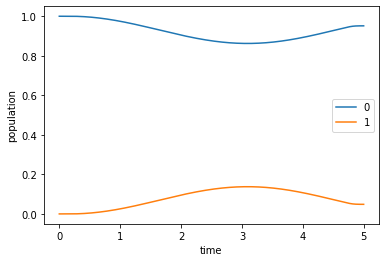

In [13]:
plot_population(guess_dynamics)

## Optimize

In the following we optimize the guess field $\epsilon_{0}(t)$ such
that the intended state-to-state transfer $\ket{\Psi_{\init}} \rightarrow
\ket{\Psi_{\tgt}}$ is solved, via the `krotov` package's central
`optimize_pulses` routine.  It requires, besides the previously defined
`objectives`, information about the optimization functional $J_T$ (implicitly,
via `chi_constructor`, which calculates the states $\ket{\chi} =
\frac{J_T}{\bra{\Psi}}$).

Here, we choose $J_T = J_{T,\text{ss}} = 1 - F_{\text{ss}}$ with $F_{\text{ss}}
= \Abs{\Braket{\Psi_{\tgt}}{\Psi(T)}}^2$, with $\ket{\Psi(T)}$ the forward
propagated state of $\ket{\Psi_{\init}}$. Even though $J_T$ is not explicitly
required for the optimization, it is nonetheless useful to be able to calculate
and print it as a way to provide some feedback about the optimization progress.
Here, we pass as an `info_hook` the function `krotov.info_hooks.print_table`,
using `krotov.functionals.J_T_ss` (which implements the above functional; the
`krotov` library contains implementations of all the "standard" functionals used in
quantum control). This `info_hook` prints a tabular overview after each
iteration, containing the value of $J_T$, the magnitude of the integrated pulse
update, and information on how much $J_T$ (and the full Krotov functional $J$)
changes between iterations. It also stores the value of $J_T$ internally in the
`Result.info_vals` attribute.

The value of $J_T$ can also be used to check the convergence. In this example,
we limit the number of total iterations to 10, but more generally, we could use
the `check_convergence` parameter to stop the optimization when $J_T$ falls below
some threshold. Here, we only pass a function that checks that the value of
$J_T$ is monotonically decreasing. The
`krotov.convergence.check_monotonic_error` relies on
`krotov.info_hooks.print_table` internally having stored the value of $J_T$ to
the `Result.info_vals` in each iteration.

In [14]:
opt_result = krotov.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_ss,
    info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_ss),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.check_monotonic_error,
    ),
    store_all_pulses=True,
)

iter.      J_T    ∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     9.51e-01    0.00e+00   9.51e-01        n/a        n/a     0
1     9.24e-01    1.20e-02   9.36e-01  -2.71e-02  -1.50e-02     1
2     8.83e-01    1.83e-02   9.02e-01  -4.11e-02  -2.28e-02     1
3     8.23e-01    2.71e-02   8.50e-01  -6.06e-02  -3.35e-02     1
4     7.37e-01    3.84e-02   7.76e-01  -8.52e-02  -4.68e-02     1
5     6.26e-01    5.07e-02   6.77e-01  -1.11e-01  -6.05e-02     1
6     4.96e-01    6.04e-02   5.56e-01  -1.31e-01  -7.02e-02     1
7     3.62e-01    6.30e-02   4.25e-01  -1.34e-01  -7.09e-02     1
8     2.44e-01    5.65e-02   3.00e-01  -1.18e-01  -6.15e-02     1
9     1.53e-01    4.39e-02   1.97e-01  -9.03e-02  -4.64e-02     1
10    9.20e-02    3.02e-02   1.22e-01  -6.14e-02  -3.12e-02     1
11    5.35e-02    1.90e-02   7.25e-02  -3.85e-02  -1.94e-02     1
12    3.06e-02    1.14e-02   4.20e-02  -2.29e-02  -1.15e-02     1
13    1.73e-02    6.60e-03   2.39e-02  -1.32e-02  -6.64e-03     1
14    9.78

In [15]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2021-11-07 05:48:09
- Number of objectives: 1
- Number of iterations: 18
- Reason for termination: Reached convergence: J_T < 1e-3
- Ended at 2021-11-07 05:48:35 (0:00:26)

## Simulate the dynamics under the optimized field

Having obtained the optimized control field, we can simulate the dynamics to
verify that the optimized field indeed drives the initial state
$\ket{\Psi_{\init}} = \ket{0}$ to the desired target state
$\ket{\Psi_{\tgt}} = \ket{1}$.

In [16]:
opt_dynamics = opt_result.optimized_objectives[0].mesolve(
    tlist, e_ops=[proj0, proj1])

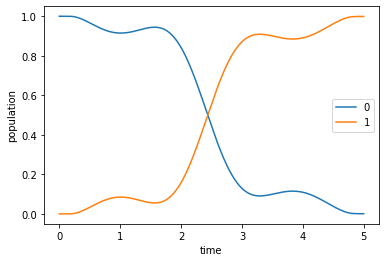

In [17]:
plot_population(opt_dynamics)

To gain some intuition on how the controls and the dynamics change throughout the optimization procedure, we can generate a plot of the control fields and the dynamics after each iteration of the optimization algorithm. This is possible because we set `store_all_pulses=True` in the call to `optimize_pulses`, which allows to recover the optimized controls from each iteration from `Result.all_pulses`. The flag is not set to True by default, as for long-running optimizations with thousands or tens of thousands iterations, the storage of all control fields may require significant memory.

In [18]:
def plot_iterations(opt_result):
    """Plot the control fields in population dynamics over all iterations.

    This depends on ``store_all_pulses=True`` in the call to
    `optimize_pulses`.
    """
    fig, [ax_ctr, ax_dyn] = plt.subplots(nrows=2, figsize=(8, 10))
    n_iters = len(opt_result.iters)
    for (iteration, pulses) in zip(opt_result.iters, opt_result.all_pulses):
        controls = [
            krotov.conversions.pulse_onto_tlist(pulse)
            for pulse in pulses
        ]
        objectives = opt_result.objectives_with_controls(controls)
        dynamics = objectives[0].mesolve(
            opt_result.tlist, e_ops=[proj0, proj1]
        )
        if iteration == 0:
            ls = '--'  # dashed
            alpha = 1  # full opacity
            ctr_label = 'guess'
            pop_labels = ['0 (guess)', '1 (guess)']
        elif iteration == opt_result.iters[-1]:
            ls = '-'  # solid
            alpha = 1  # full opacity
            ctr_label = 'optimized'
            pop_labels = ['0 (optimized)', '1 (optimized)']
        else:
            ls = '-'  # solid
            alpha = 0.5 * float(iteration) / float(n_iters)  # max 50%
            ctr_label = None
            pop_labels = [None, None]
        ax_ctr.plot(
            dynamics.times,
            controls[0],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
        ax_dyn.plot(
            dynamics.times,
            dynamics.expect[0],
            label=pop_labels[0],
            color='#1f77b4',  # default blue
            ls=ls,
            alpha=alpha,
        )
        ax_dyn.plot(
            dynamics.times,
            dynamics.expect[1],
            label=pop_labels[1],
            color='#ff7f0e',  # default orange
            ls=ls,
            alpha=alpha,
        )
    ax_dyn.legend()
    ax_dyn.set_xlabel('time')
    ax_dyn.set_ylabel('population')
    ax_ctr.legend()
    ax_ctr.set_xlabel('time')
    ax_ctr.set_ylabel('control amplitude')
    plt.show(fig)

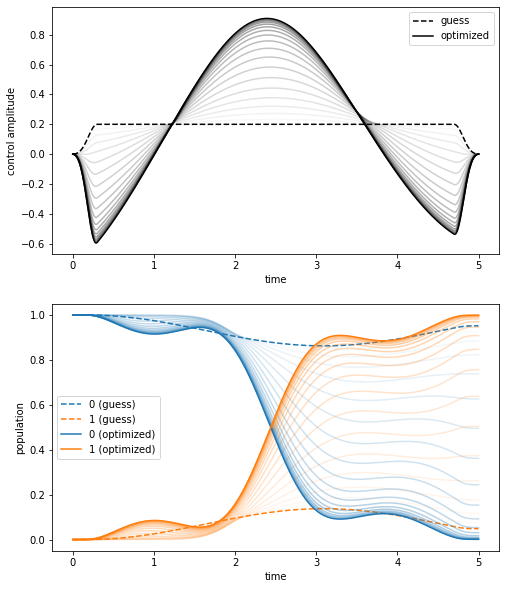

In [19]:
plot_iterations(opt_result)

The initial guess (dashed) and final optimized (solid) control amplitude and resulting dynamics are shown with full opacity, whereas the curves corresponding intermediate iterations are shown with decreasing transparency.